# Logistic regression model with CV and lasso regularisation 

**Questions :**
- What number of iterations to ensure convergence ?
- What lasso regularisation parameter ?
- What cross-validation method ?
- Validation/in/out sample sizes


**ISSUES :**
- missing values in the eeg : drop or try to replace ?
- convergence of the model

**Notes :**
- no significant class imbalance 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

## Preamble

In [3]:
from source.preamble import *

train_eeg_names = os.listdir(Dir.eeg_train)
train_spc_names = os.listdir(Dir.spc_train)
len(train_eeg_names), len(train_spc_names)

(17300, 11138)

## Functions definition

In [4]:
from source.classes import Eeg, ChainBuilder, EegChain, FeatureGenerator
from source.scoring import compute_wasserstein, score
from source.train_algos import (
    train_logistic_regression_CV,
    test_model,
    predict_probas_test_set,
)
from source.process import open_train_metadata, print_summary_metadata
from source.pre_train import extract_validation_set
from source.plotting import plot_coefs

## Process metadata

In [5]:
meta_all = open_train_metadata(read=False)
print_summary_metadata(meta_all)
meta_all.iloc[:10]

Metadata summary :
Len :  106800


,n_sample,percent
expert_consensus,,
GPD,16702,15
GRDA,18861,17
LPD,14856,13
LRDA,16640,15
Other,18808,17
Seizure,20933,19


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes,eeg_length
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,1.0,0.0,0.000000,0.0,0.000000,0.000000,3,50
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0,0.454545,0.0,0.090909,0.454545,11,50


In [6]:
# store the processed meta df as it takes a while (checking for na values in all train files mainly)
# if not KAGGLE and (
#     not os.path.exists(
#         os.path.join(Dir.intermediate_output, "meta_train_extended.parquet")
#     )
# ):
#     meta_all.to_parquet(
#         os.path.join(Dir.intermediate_output, "meta_train_extended.parquet")
#     )

## Sample class usage
Just an example

EEG sub id :  1


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
17996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
17997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
17998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
1200,-129.460007,-115.580002,-115.129997,-157.440002,-166.979996,-126.260002,-133.429993,-124.349998,-116.629997,-112.110001,-117.040001,-103.169998,-100.070000,-133.970001,-103.449997,-100.059998,-90.040001,-132.460007,-107.230003,-5.900000
1201,-128.740005,-112.330002,-112.059998,-154.830002,-164.440002,-121.230003,-135.380005,-122.269997,-114.930000,-107.370003,-111.059998,-100.480003,-96.330002,-122.019997,-95.400002,-98.309998,-83.660004,-122.070000,-97.180000,9.670000
1202,-128.600006,-112.550003,-107.489998,-148.360001,-154.089996,-114.110001,-129.470001,-115.989998,-123.620003,-104.839996,-100.190002,-104.250000,-106.040001,-116.940002,-96.059998,-96.620003,-91.120003,-127.430000,-93.900002,-3.030000
1203,-123.449997,-106.440002,-108.870003,-148.309998,-158.080002,-118.129997,-133.350006,-117.790001,-106.150002,-95.480003,-97.440002,-93.980003,-90.500000,-109.900002,-86.510002,-93.559998,-86.019997,-121.650002,-92.110001,33.880001
1204,-129.770004,-119.430000,-111.879997,-148.029999,-145.830002,-118.040001,-140.699997,-113.980003,-97.209999,-85.459999,-91.620003,-83.529999,-71.750000,-96.820000,-71.599998,-85.779999,-68.370003,-105.889999,-85.059998,65.309998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11195,-156.139999,-149.660004,-115.019997,-130.360001,-167.929993,-94.500000,-117.029999,-130.899994,-137.979996,-129.869995,-122.279999,-127.019997,-133.919998,-183.699997,-83.559998,-112.889999,-124.989998,-150.190002,-126.360001,100.959999
11196,-168.899994,-157.619995,-168.679993,-141.410004,-199.839996,-118.550003,-114.269997,-132.399994,-169.940002,-158.889999,-131.960007,-159.110001,-186.610001,-278.440002,-106.930000,-113.339996,-1.440000,-167.160004,-134.429993,120.190002
11197,-164.080002,-143.070007,-211.740005,-165.570007,-201.369995,-90.730003,-120.489998,-134.940002,-170.300003,-168.910004,-143.000000,-159.619995,-211.259995,-271.290009,-116.010002,-68.989998,-131.259995,-179.529999,-141.350006,148.399994
11198,-168.080002,-148.940002,-118.269997,-145.429993,-162.889999,-128.440002,-120.709999,-123.620003,-124.800003,-108.779999,-117.269997,-135.500000,-126.430000,-23.309999,-87.169998,-90.980003,-148.750000,-162.380005,-129.490005,123.660004


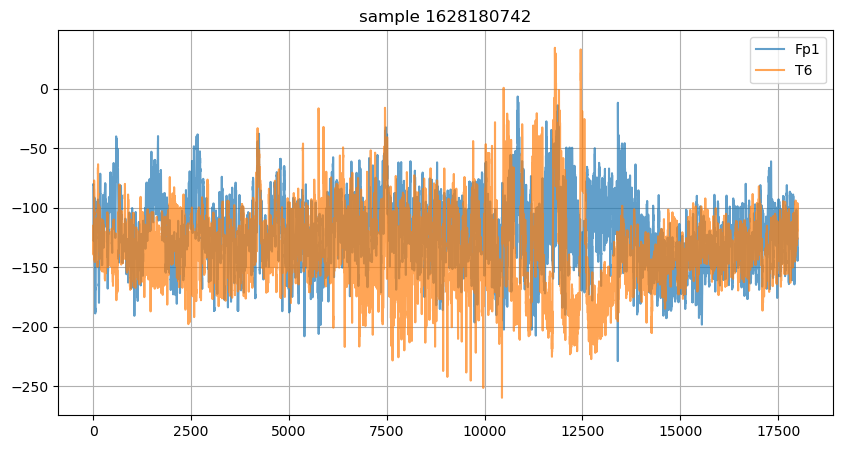

In [7]:
eeg = Eeg(Dir.eeg_train, meta_all.iloc[1])
print("EEG sub id : ", eeg.eeg_sub_id)
display(eeg.open())  # the whole EEG
display(eeg.open_subs())  # only the selected subsample
eeg.plot(columns=["Fp1", "T6"])

In [8]:
eeg_chain_train = lambda sample: (
    EegChain()
    .open(Eeg(Dir.eeg_train, sample))
    ._fillna()
    ._divide(coef=1000.0)
    .mean(cols=["Fp1", "EKG"])
    .var(cols=["EKG"])
    .signature(
        cols=["Fp1", "EKG", "F7", "T3", "O2"],
        depth=3,
        index=[i for i in range(ChainBuilder.n_sig_coordinates(5, 3))],
        parameterise=True,
    )
    .result()
)

feature_generator = FeatureGenerator(eeg_chain=eeg_chain_train)

meta_sample = meta_all.iloc[:100]

features = feature_generator.process(metadata=meta_sample, save=False)
features

,Fp1-mean,EKG-mean,EKG-var,sig-(),sig-(2),sig-(3),sig-(4),sig-(5),"sig-(1,1)","sig-(1,3)",...,"sig-(5,4,1)","sig-(5,4,2)","sig-(5,4,3)","sig-(5,4,4)","sig-(5,4,5)","sig-(5,5,1)","sig-(5,5,2)","sig-(5,5,3)","sig-(5,5,4)","sig-(5,5,5)"
eeg_id,,,,,,,,,,,,,,,,,,,,,
1628180742,-0.117237,0.016077,0.050067,1.0,-0.05082,0.01763,-0.00284,0.00596,-0.00789,-141.001890,...,0.001605,-0.420259,-0.013248,-0.020081,0.007114,-1.023713e+06,-3.515406,-2.772017,-13.846263,-11.223740
1628180742,-0.117181,0.015293,0.050846,1.0,-0.03695,0.10807,-0.04524,0.01525,-0.02633,-492.267816,...,0.006697,-0.250066,0.014523,-0.004452,0.012574,1.228052e+06,-18.502798,20.243752,-26.512765,-4.441712
1628180742,-0.118178,0.014988,0.050578,1.0,-0.03949,0.17994,-0.09799,-0.03118,-0.04057,2.500840,...,-0.009504,-0.204089,0.000607,0.003456,0.010839,-3.074037e+06,-6.700145,-107.609370,12.644564,7.757949
1628180742,-0.115651,0.014743,0.050227,1.0,0.04395,-0.12296,0.03698,0.05744,-0.04503,210.790995,...,-0.013772,-0.158892,-0.006716,-0.006023,0.001614,1.505388e+06,0.761666,-52.232981,-6.865778,0.650110
1628180742,-0.117538,0.011713,0.049154,1.0,-0.03094,0.05833,-0.07580,-0.07144,0.05585,-137.605923,...,-0.000863,-0.233044,0.000907,0.009662,-0.014157,-2.600407e+06,0.827856,-38.560041,3.697691,16.216679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893864755,-0.010563,0.004429,0.003238,1.0,-0.05735,0.00865,-0.10351,-0.11353,0.00671,-257.144202,...,-0.001775,-0.035095,-0.003135,-0.003925,-0.000275,-2.639924e+06,4.077601,-4.134151,13.474087,26.887818
3669581453,-0.116418,0.014463,0.010591,1.0,0.64488,0.37912,0.66667,0.57474,0.58813,1012.756999,...,0.075353,0.035002,0.071086,0.117269,-0.001608,2.363672e+07,307.790033,297.966645,411.156740,244.311650
3669581453,-0.078232,0.034246,0.007329,1.0,0.35331,0.21264,0.38021,0.39810,0.33571,-351.755331,...,0.093516,-0.121868,0.074988,0.047529,0.010278,1.760047e+07,-207.155456,236.876747,-122.401743,82.648262


## Train
- make sure not to generate class imbalance
- seed should be fixed in local for debug

In [9]:
# split validation
rest_meta, validation_meta = extract_validation_set(meta_all, ratio=0.02)
print_summary_metadata(rest_meta)
print_summary_metadata(validation_meta)

Metadata summary :
Len :  104664


,n_sample,percent
expert_consensus,,
GPD,16366,15
GRDA,18512,17
LPD,14553,13
LRDA,16305,15
Other,18417,17
Seizure,20511,19


Metadata summary :
Len :  2136


,n_sample,percent
expert_consensus,,
GPD,336,15
GRDA,349,16
LPD,303,14
LRDA,335,15
Other,391,18
Seizure,422,19


In [42]:
# parameters
max_nsample = 1000 if KAGGLE else 10000
max_it = 1200
cs = 0.05

eeg_chain_train = lambda sample: (
    EegChain()
    .open(Eeg(Dir.eeg_train, sample))
    ._fillna()
    ._divide(coef=1000.0)
    .mean(cols=["Fp1", "EKG"])
    .var(cols=["EKG"])
    .signature(
        cols=["Fp1", "EKG", "F7", "T3", "O2"],
        depth=3,
        index=[i for i in range(ChainBuilder.n_sig_coordinates(5, 3))],
        parameterise=True,
    )
    .result()
)

feature_generator = FeatureGenerator(
    eeg_chain=eeg_chain_train,
    save=os.path.join(Dir.intermediate_output, "eeg_features_train.parquet"),
)

model, *other = train_logistic_regression_CV(
    rest_meta,
    feature_generator,
    VOTE_COLS,
    max_it=max_it,
    max_nsample=max_nsample,
    grade=Grade.certain,
    scale=True,
    Cs=[cs],
    fit_intercept=False,
)

c:\miniconda3\envs\hms\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-

In [43]:
# feature_generator._save(data=features, path=os.path.join(Dir.intermediate_output, "eeg_features_train.parquet"))

In [44]:
# keep the same preprocessing for the test and validation data
scaler = other[0]

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'Coefficient values'}>,
        <Axes: title={'center': 'Lasso unselected coefs (160 out of 936 remaining)'}>],
       dtype=object))

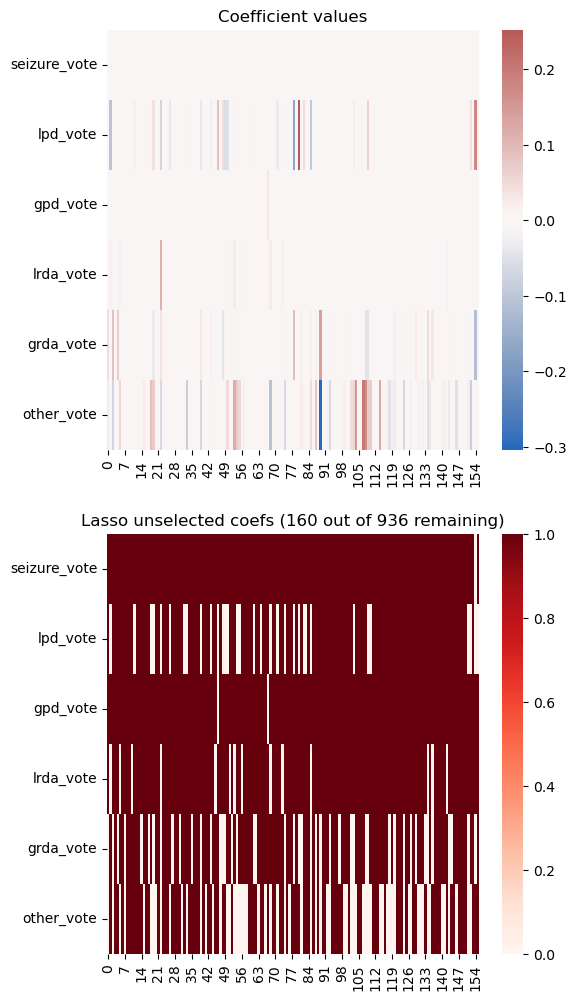

In [45]:
plot_coefs(model)

### Tune lasso regularisation parameter

	Cs= 0.1
Number of samples without missing values selected :  809
(809, 40) (809,)


c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Number of samples without missing values selected :  8948
Wasserstein metric : 1.385537083857391


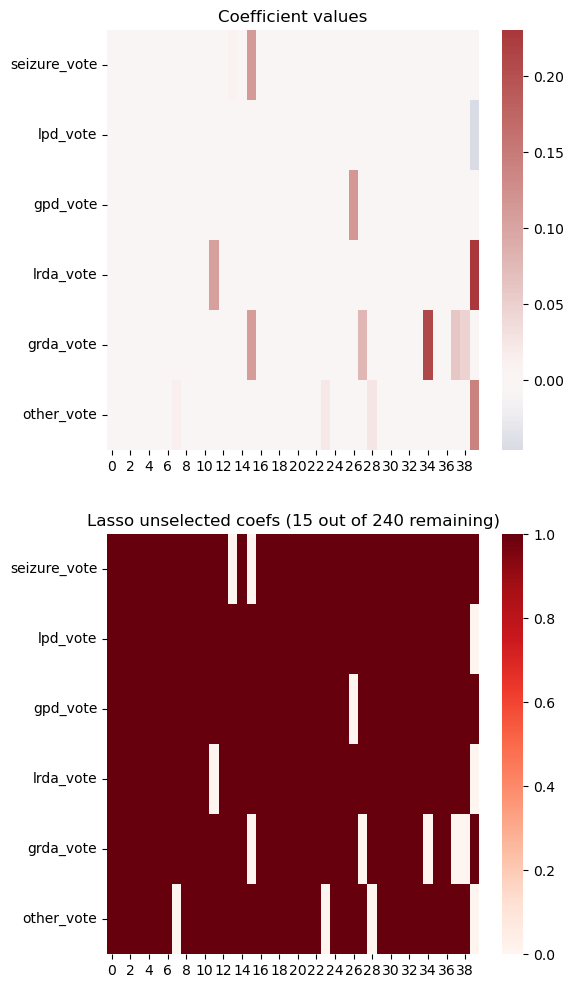

	Cs= 1.0
Number of samples without missing values selected :  809
(809, 40) (809,)


c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\miniconda3\envs\hms\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached 

Number of samples without missing values selected :  8948
Wasserstein metric : 1.323104775689118


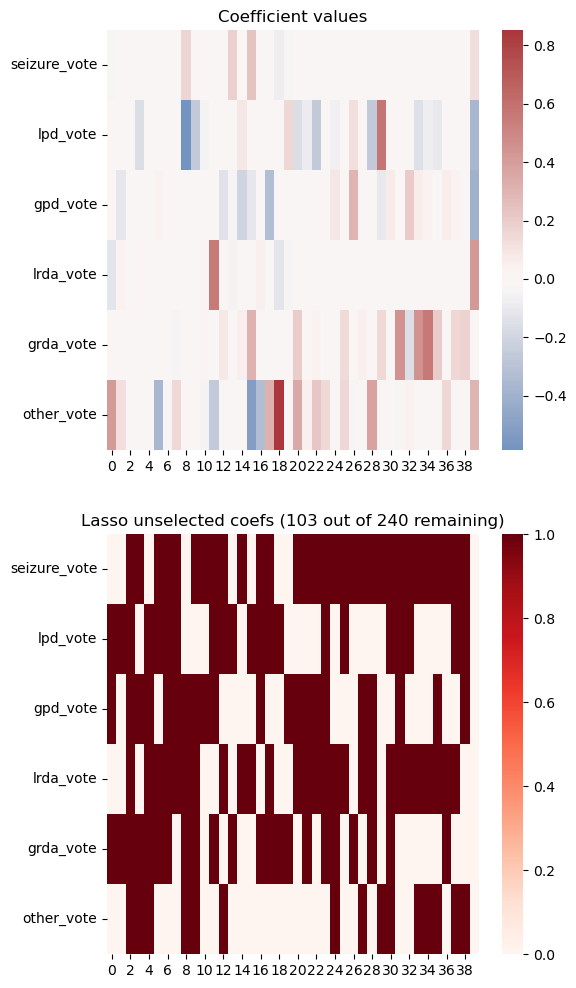

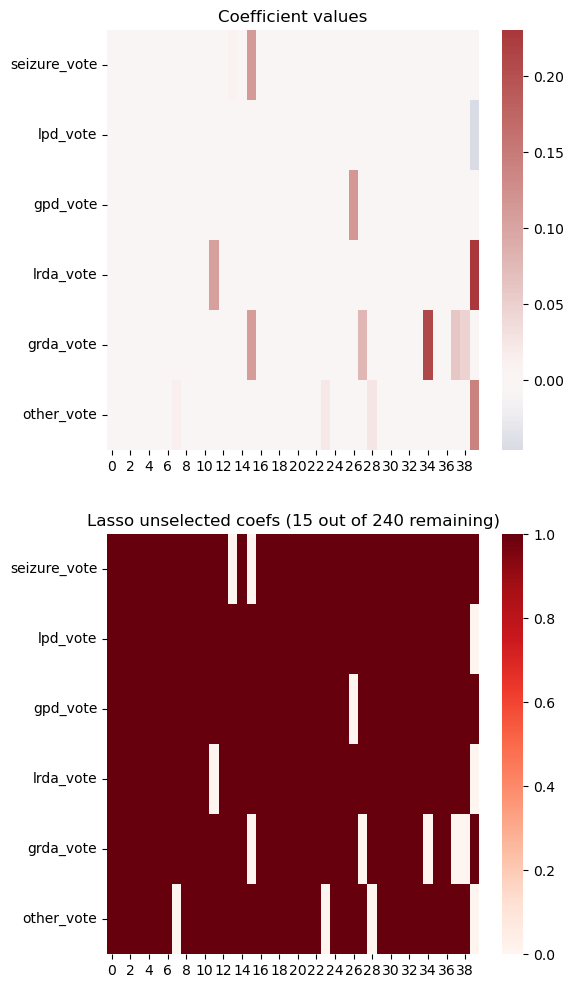

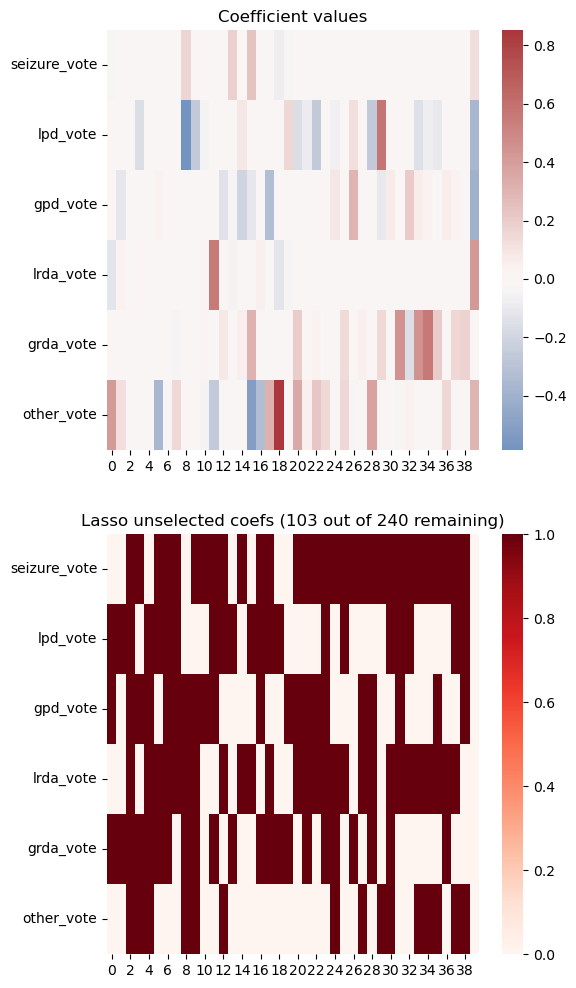

In [ ]:
max_nsample = 1000 if KAGGLE else 1000
max_it = 1000
csx = np.linspace(0.1, 1, 2, endpoint=True)
for cs in csx:
    print("=" * 50)
    print("\tCs=", cs)
    model, *other = train_logistic_regression_CV(
        rest_meta,
        VOTE_COLS,
        max_it=max_it,
        max_nsample=max_nsample,
        grade=Grade.certain,
        scale=True,
        Cs=[cs],
    )
    scaler = other[0]
    predicted_probas = test_model(model, VOTE_COLS, validation_meta, scaler)
    print("Wasserstein metric :", compute_wasserstein(predicted_probas, target_probas))
    fig, _ = plot_coefs(model)
    display(fig)

- Tune lasso regularisation parameter :
    - with Logistic regression **10 fold CV** and **Z-score scaling** 
    - 1000 train samples
    - max solver iteration = 1000 (saga)
    - **CONVERGENCE ISSUES** (max iteration reached)
    - *TAKEAWAY* :
        - min generalisation error between 1. and 3.
        - Cs = .1 selects only few features per class
        - Var(EKG) always selected


In [70]:
target_probas

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
12800,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
43918,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
26217,0.470588,0.411765,0.117647,0.000000,0.0,0.000000
27450,0.000000,0.000000,0.000000,0.000000,0.5,0.500000
40535,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
...,...,...,...,...,...,...
31991,0.000000,0.000000,0.000000,0.461538,0.0,0.538462
23323,0.000000,0.000000,0.000000,0.000000,0.2,0.800000
100394,0.000000,0.133333,0.000000,0.866667,0.0,0.000000
71001,1.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [62]:
np.sum(~validation_meta["contains_na"])

10643

In [66]:
validation_meta.loc[validation_meta["eeg_length"] == 0.0]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes,eeg_length,contains_na
67307,3326858112,0,0.0,1350125538,0,0.0,666448925,61168,Other,0.000000,0.000000,0.0,0.000000,0.0,1.000000,2,0,False
3648,319937036,0,0.0,58683771,95,2984.0,3317194155,3838,GRDA,0.000000,0.000000,0.0,0.000000,1.0,0.000000,1,0,False
17271,979338839,0,0.0,341741176,0,0.0,1042455753,33133,LPD,0.055556,0.722222,0.0,0.055556,0.0,0.166667,18,0,False
37172,3943767913,0,0.0,732003477,0,0.0,1395326711,51024,GPD,0.000000,0.000000,1.0,0.000000,0.0,0.000000,1,0,False
101538,1177070578,0,0.0,2034924566,2,142.0,860379257,14965,Seizure,1.000000,0.000000,0.0,0.000000,0.0,0.000000,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35415,2911998241,0,0.0,698197713,0,0.0,4219354894,40224,LRDA,0.000000,0.000000,0.0,0.500000,0.0,0.500000,2,0,False
104414,3332112285,0,0.0,2084996711,0,0.0,193505515,32068,Other,0.000000,0.000000,0.0,0.000000,0.0,1.000000,2,0,False
19154,3226868638,0,0.0,371630811,0,0.0,2176501626,20547,Other,0.000000,0.000000,0.0,0.000000,0.0,1.000000,1,0,False
103825,384500048,0,0.0,2074135650,47,3604.0,3871705779,61174,Other,0.000000,0.000000,0.0,0.000000,0.0,1.000000,2,0,False


In [63]:
validation_meta.loc[validation_meta["contains_na"]]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes,eeg_length,contains_na
25070,1944688715,1,2.0,492373983,237,1370.0,2657681807,42180,Seizure,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,4,True
58135,2900326159,22,64.0,1166527818,49,1498.0,3676162431,56201,GPD,0.333333,0.000000,0.666667,0.000000,0.000000,0.000000,3,4,True
6516,3711709881,9,76.0,122270690,53,1104.0,3754740334,29279,Seizure,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,22,True
63099,2756079796,0,0.0,1267185050,8,828.0,3656458872,45536,Seizure,0.500000,0.000000,0.400000,0.000000,0.000000,0.100000,20,24,True
17292,805558165,2,30.0,342523595,2,30.0,2732681896,14386,LPD,0.000000,0.666667,0.000000,0.000000,0.111111,0.222222,18,16,True
9861,3360776627,0,0.0,180318142,0,0.0,932426322,46501,GRDA,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3,6,True
37450,788653799,3,8.0,740071908,3,8.0,1598969684,34298,LRDA,0.000000,0.333333,0.000000,0.666667,0.000000,0.000000,3,2,True
104157,1111032603,2,6.0,2080191868,2,6.0,1350147818,14386,GRDA,0.000000,0.307692,0.000000,0.076923,0.384615,0.230769,13,8,True
66649,447866351,0,0.0,1339508223,0,0.0,1667820655,21875,LRDA,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3,2,True
36342,84103002,5,10.0,714828386,5,10.0,3567923230,37094,GPD,0.000000,0.000000,0.928571,0.000000,0.000000,0.071429,14,2,True


## Test
Not yet defined how to deal with NA values in the signals 
=> they are skipped for now

Also need to fix the computation of the subsample length (at each change of file)
=> those are skipped as well

"clean" => keep only data that has no issue
In the future should not drop any test values

In [26]:
mask = validation_meta["eeg_length"] > 0.0  # & (~validation_meta["contains_na"])
validation_meta_clean = validation_meta.loc[mask]

In [46]:
if not KAGGLE:
    feature_generator = FeatureGenerator(
        eeg_chain=eeg_chain_train,
        save=os.path.join(Dir.intermediate_output, "eeg_features_test.parquet"),
    )
    predicted_probas = test_model(
        model, feature_generator, VOTE_COLS, validation_meta_clean, scaler
    )

In [18]:
# UNIFORM PREDICTED PROBAS
# most basic benchmark
pp = [1.0 / 6] * 6
predicted_probas_uniform = np.array([pp for _ in range(len(validation_meta_clean))])

**Note** : 
for nsample < 30000 and maxit < 2000, the uniform benchmark is not even outperformed

(with the very simple set of features)

Classes not linearly separable, even with terms of the signature.

In [22]:
Dir.intermediate_output

<Dir.intermediate_output: 'c:\\code\\hms-harmful-brain-activity-classification\\hms-harmful-brain-activity-utils\\..\\intermediate_output'>

In [19]:
if not KAGGLE:
    target_probas = validation_meta_clean[VOTE_COLS]

In [20]:
score(predicted_probas_uniform, target_probas.values)

,MSE,Wasserstein,KullbackLDiv
0,0.002775,1.429081,0.23276


In [21]:
score(predicted_probas, target_probas.loc[mask].values)

,MSE,Wasserstein,KullbackLDiv
0,0.00279,1.400375,0.252059


> confusion matrix to visualise which classes are better classified

## Submission

In [19]:
# the true test samples
meta_test = pd.read_csv(os.path.join(Dir.root, "test.csv"))

In [20]:
sub = predict_probas_test_set(model, meta_test)
sub.to_csv(os.path.join(Dir.out, "submission.csv"))
sub

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
eeg_id,,,,,,
3911565283,2.179683e-128,7.680235e-128,2.823597e-128,1.0,1.035273e-77,1.395644e-127
